# Running the enrichment methods on pbmc single cell data at a high resolution, showing performance to identify over/under-clustering instances.
                           
### INPUT: 

 * data/test_data/pbmc.h5ad
 
### OUTPUT: 

 * NONE, plots within
 
## Environment Setup

In [5]:
work_dir = '.' #Path to where Cytocipher_manuscript installed
import os, sys
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scvelo as scv
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import importlib as imp
import cytocipher as cc

data_dir = 'data/test_data/'

## Preparing/Loading the data

In [3]:
data = sc.read_h5ad(data_dir+'pbmc.h5ad')

In [4]:
data.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'leiden'],
      dtype='object')

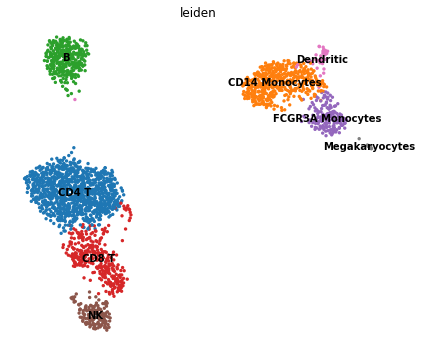

In [5]:
fig, ax = plt.subplots(figsize=(6, 5))
sc.pl.umap(data, color=['leiden'], legend_loc='on data', ax=ax, show=False, frameon=False, 
          #add_outline=True,
          )

In [6]:
import warnings
warnings.filterwarnings("ignore")

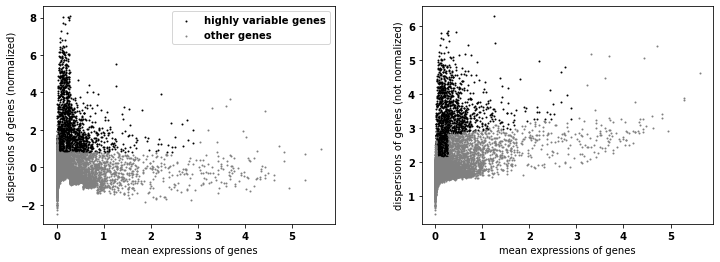

1398


In [7]:
sc.pp.highly_variable_genes(data, min_disp=.8)
sc.pl.highly_variable_genes(data)
print(sum(data.var['highly_variable']))

## Performing the normal-clustering on the data

In [8]:
col = 'leiden_col'
n_cpus=5

In [9]:
sc.tl.leiden(data, 
             resolution=2,
             key_added=col)

<AxesSubplot:title={'center':'leiden_col'}, xlabel='UMAP1', ylabel='UMAP2'>

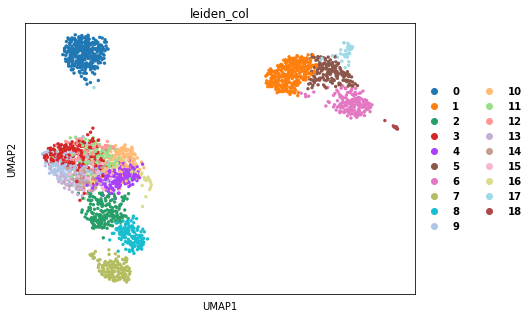

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))
sc.pl.umap(data, color=col, ax=ax, show=False,
          )

In [13]:
# Measuring how well the 'clustering' model fits the data....
cc.tl.get_markers(data, col, n_top=6)
cc.tl.code_enrich(data, col, n_cpus=n_cpus)

Added data.uns['leiden_col_markers']
Added data.obsm['leiden_col_enrich_scores']


In [14]:
#### Do per cell, but subset to x cells per cell type so can see...
cell_indices = []
labels = data.obs[col].values.astype(str)
label_set = np.unique( labels )
for i, label in enumerate(label_set):
    indices = np.where(labels==label)[0]
    cell_indices.extend( np.random.choice(indices, min([len(indices), 50]), replace=False) )

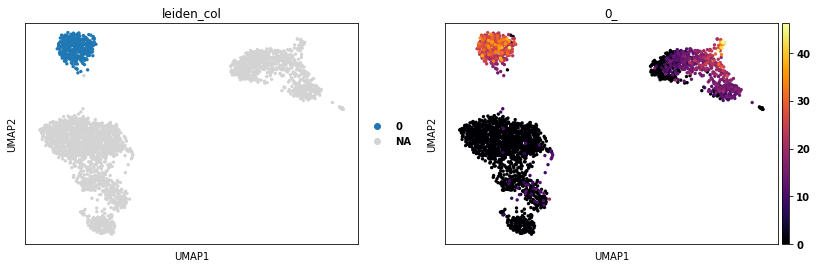

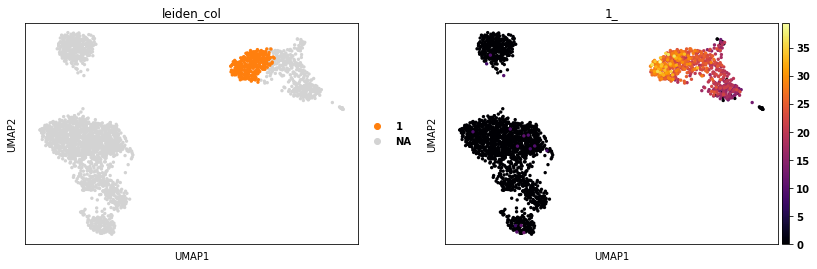

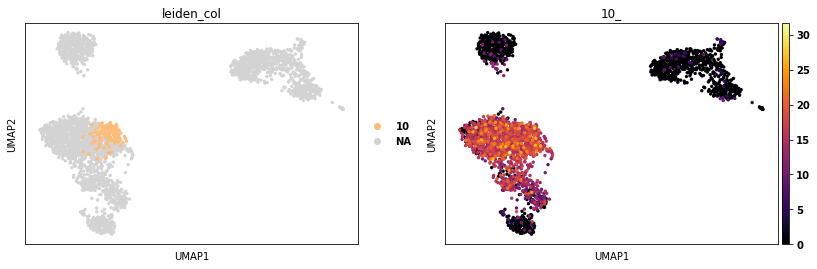

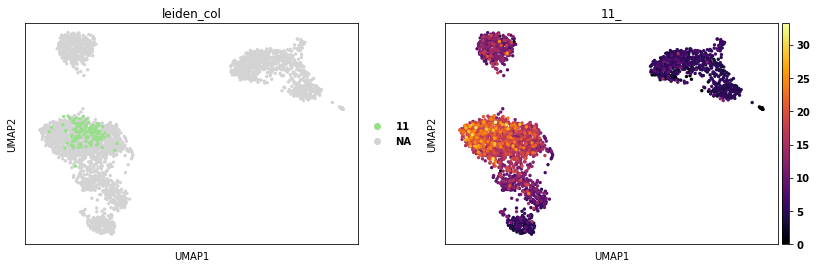

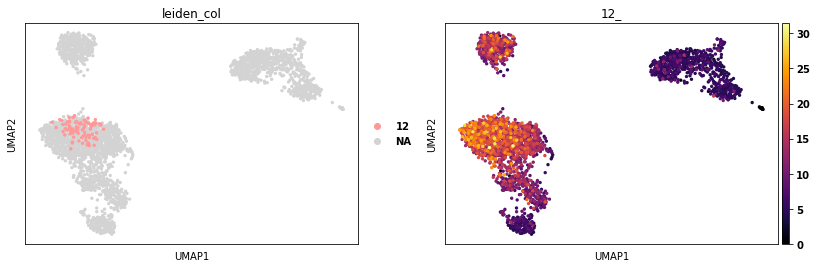

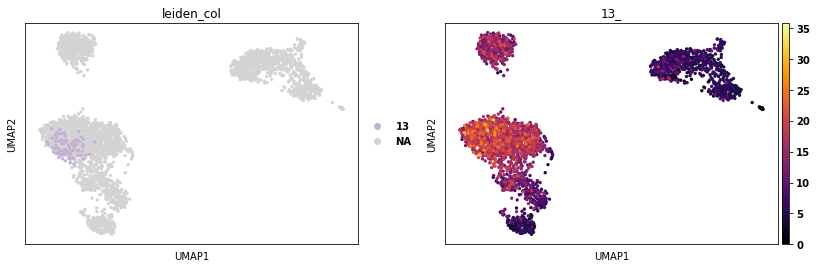

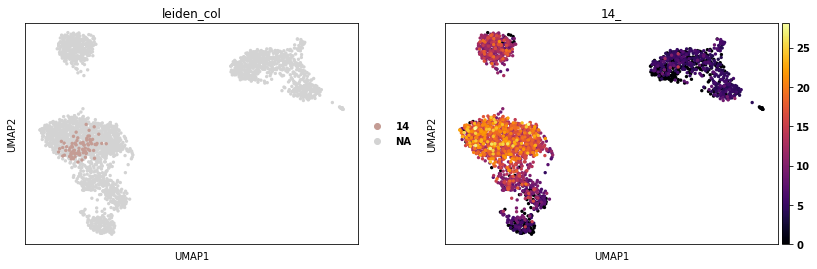

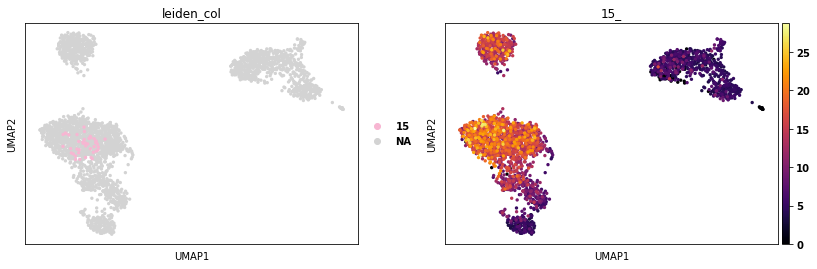

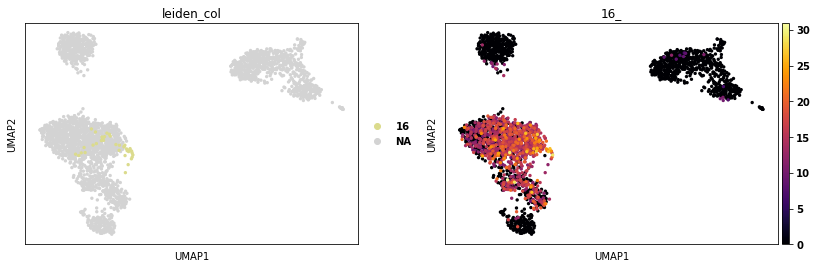

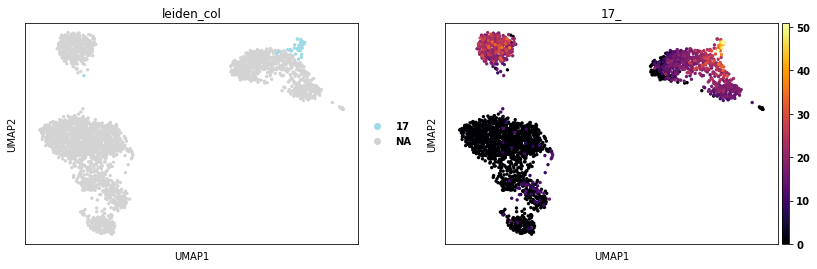

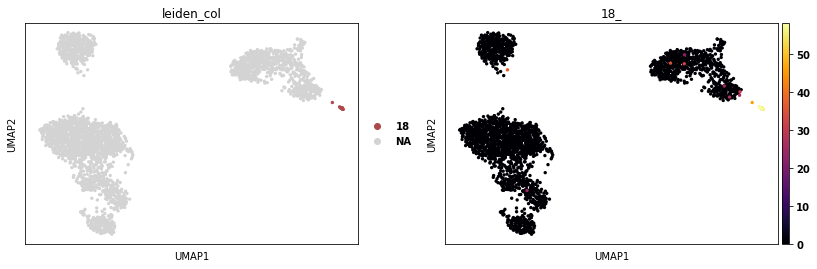

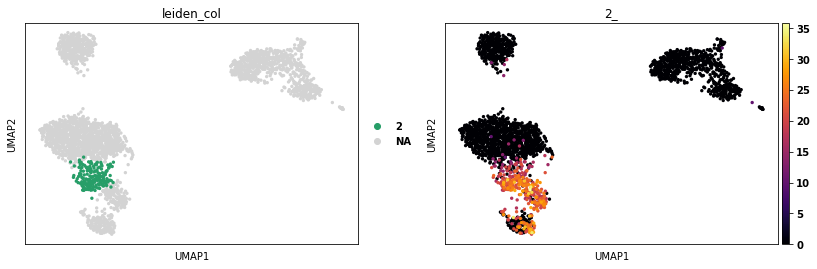

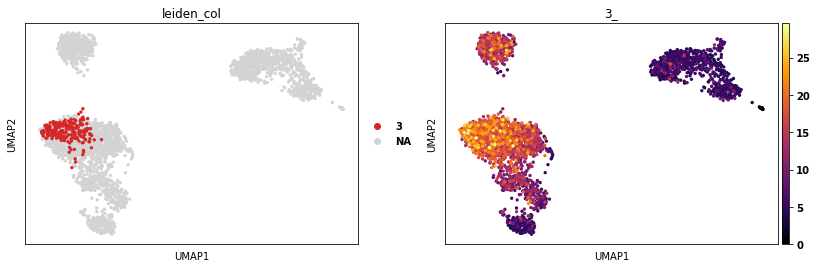

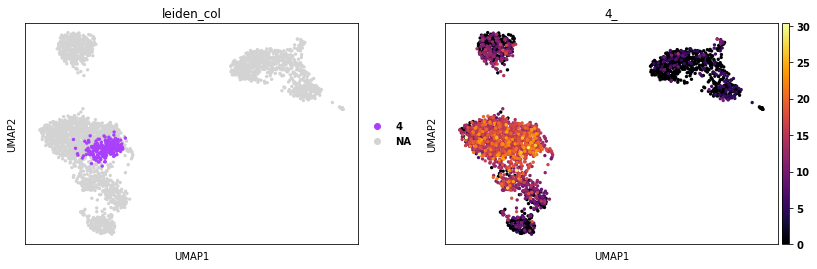

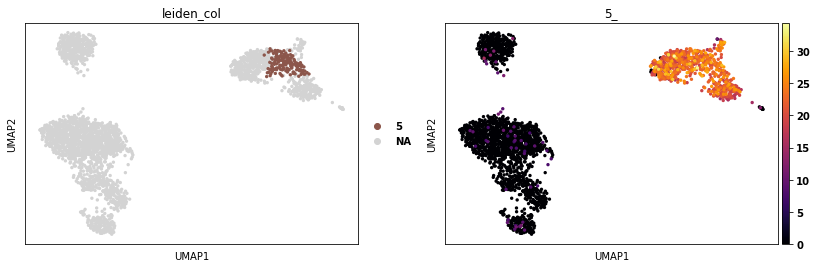

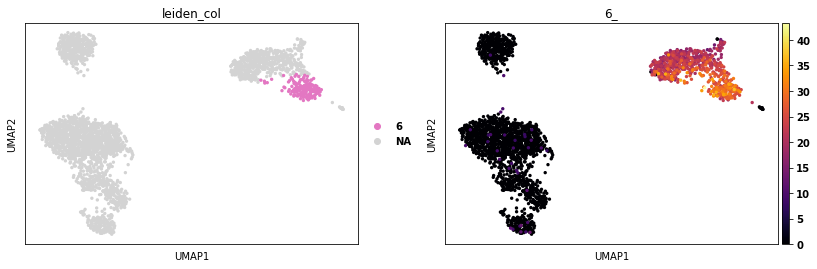

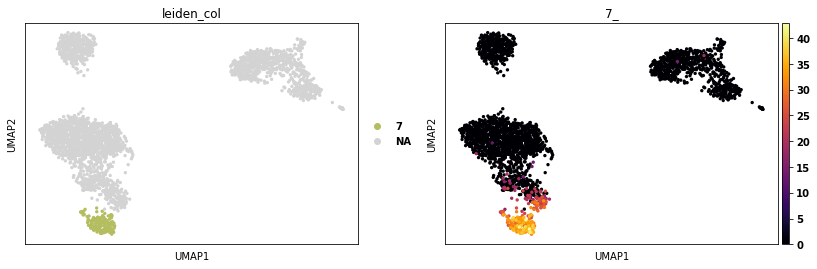

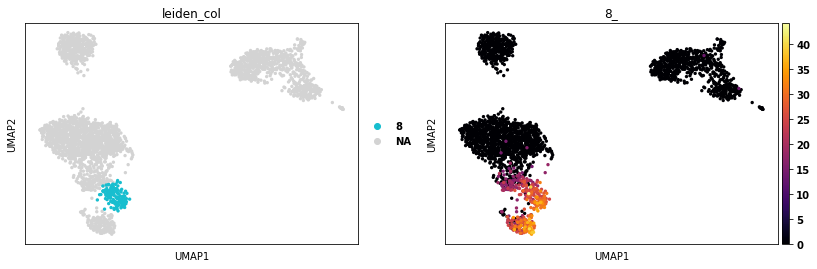

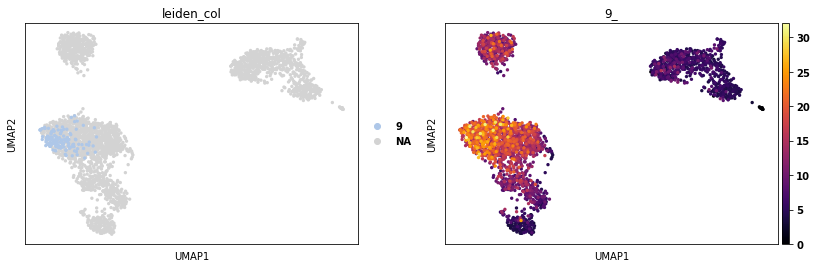

In [15]:
cmap = 'inferno'

for label in label_set:   
    data.obs[f'{label}_'] = data.obsm[f'{col}_enrich_scores'].loc[:, label].values
    sc.pl.umap(data, color=[col, f'{label}_'], groups=[label], cmap=cmap, show=True)

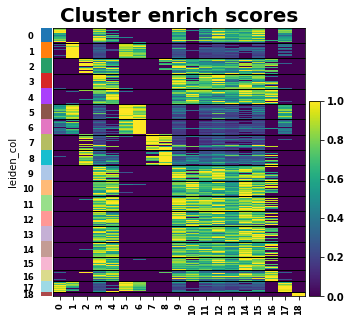

In [17]:
cc.pl.enrich_heatmap(data, col, figsize=(5,5))

# Now let's see if we can show which clusters are significantly different from one another using the enrichment scores.

NOTE that this is taken from neurotools cluster scoring, in order to break down internally how the method is performing and show the justification for the approach taken.

In [18]:
leiden_col = 'leiden_test'

ress = np.array(list(range(1, 30)))/8
ress

array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125,
       1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 ,
       2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375,
       3.5  , 3.625])

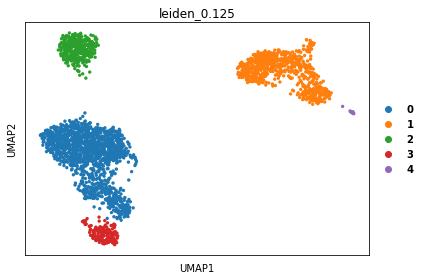

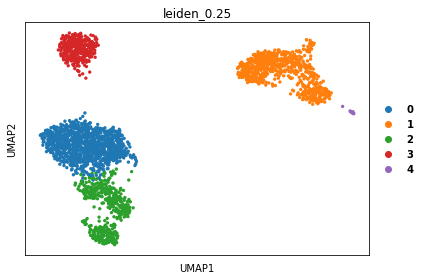

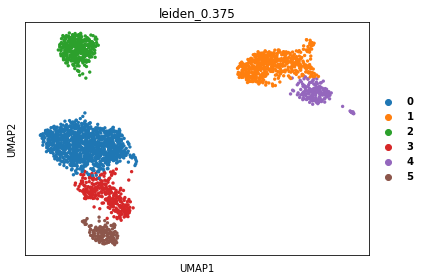

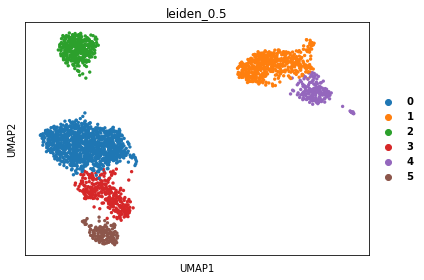

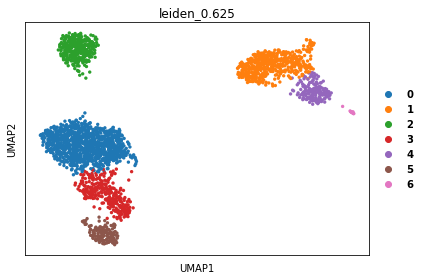

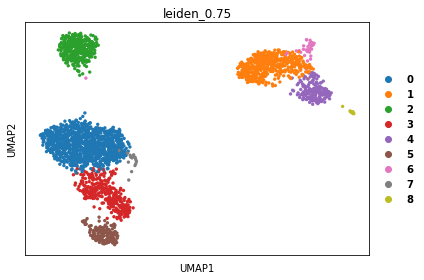

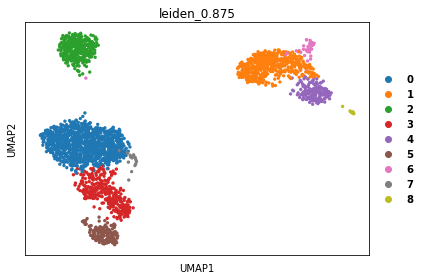

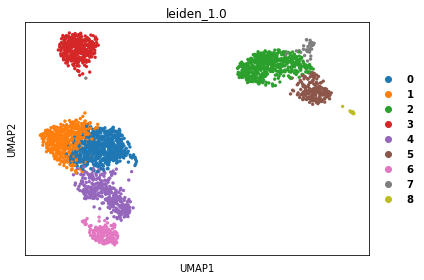

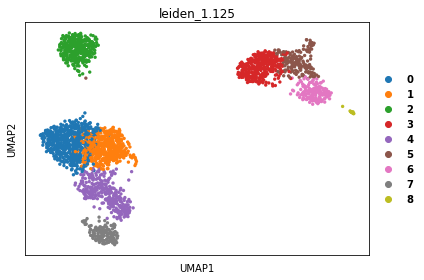

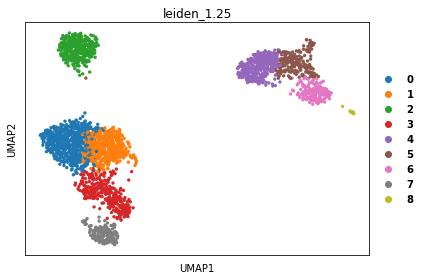

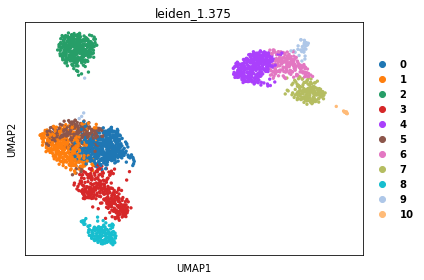

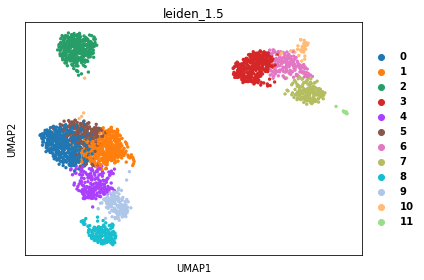

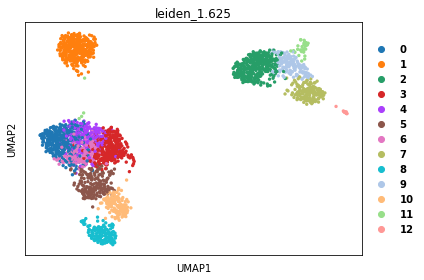

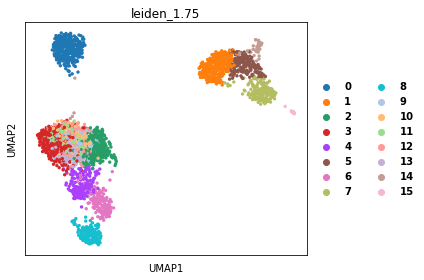

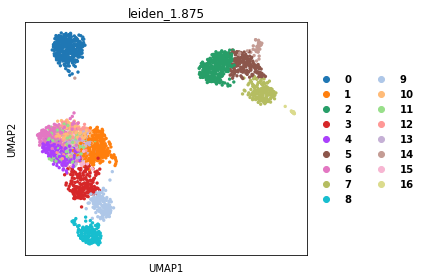

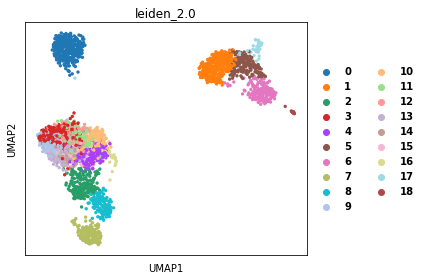

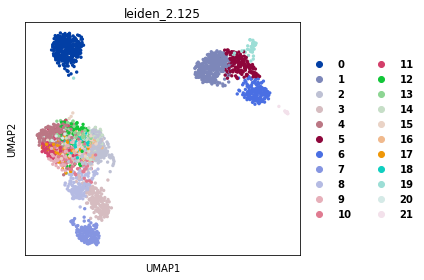

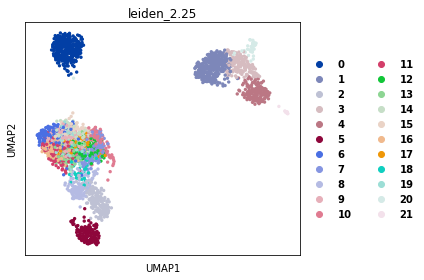

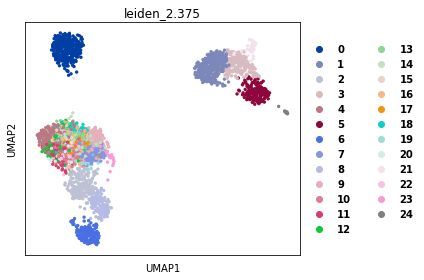

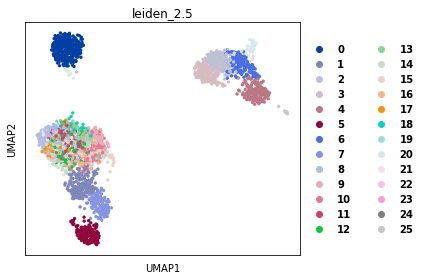

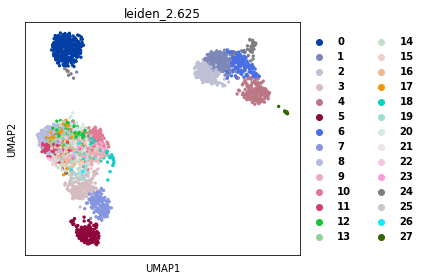

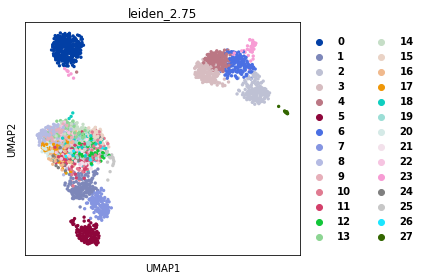

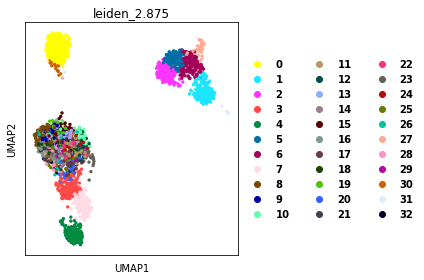

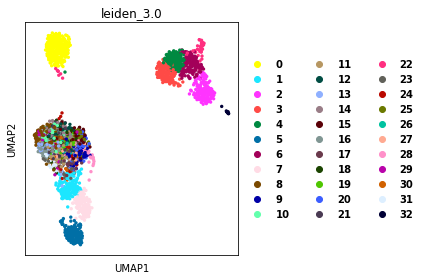

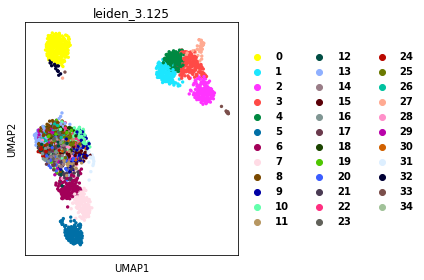

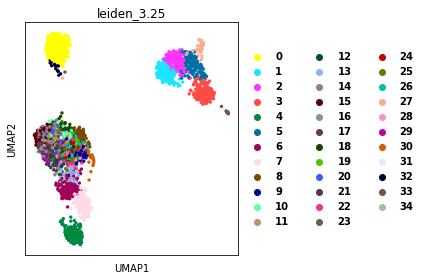

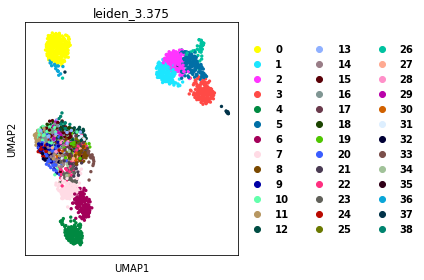

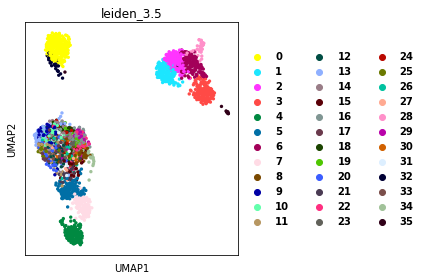

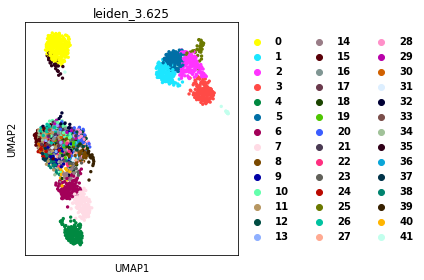

In [157]:
for res in ress:
    leiden_col = f'leiden_{res}'
    sc.tl.leiden(data, 
                 resolution=res,
                 key_added=leiden_col)
    sc.pl.umap(data, color=leiden_col, show=True)

## Double-checking get same results when doing a run-through without looking at the distributions

NOTE; neurotools is already a python package; need to update to neuroscan (neuronal-single-cell-analysis).

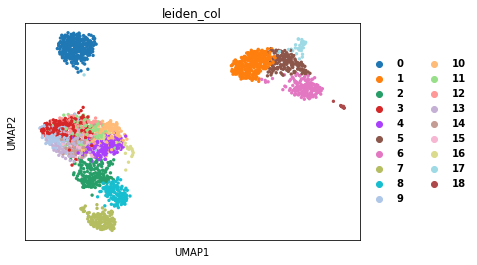

In [19]:
col = 'leiden_col' # Over-clustered
sc.pl.umap(data, color=col)

In [24]:
##### Looking at the scores with over-clustering.
# Calling cluster marker genes #
cc.tl.get_markers(data, col)

# Running code enrichment #
n_cpus = 6
cc.tl.code_enrich(data, col, n_cpus=n_cpus)

Added data.uns['leiden_col_markers']
Added data.obsm['leiden_col_enrich_scores']


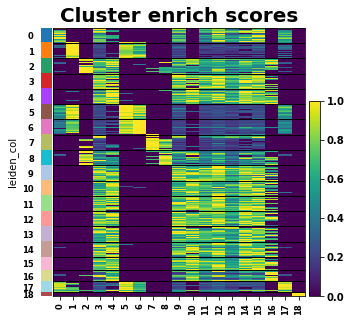

In [20]:
#### Visualising enrichment scores per cell
#### Do per cell, but subset to x cells per cell type so can see... 
cc.pl.enrich_heatmap(data, col, figsize=(5,5))

In [21]:
cc.tl.merge_clusters(data, col, n_cpus=5
                     )

Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0


In [22]:
#### Setting colors to better align with the original clustering...
orig_colors = {clust: data.uns[f'{col}_colors'][i] for i, clust in enumerate(data.obs[col].cat.categories)}
new_colors = {'2': orig_colors['0'], '3': orig_colors['9'], '6': orig_colors['6'],
              '4': orig_colors['18'], '5': orig_colors['2'], '8': orig_colors['8'],
              '7': orig_colors['7'], '1': 'gold', '0': 'coral'
             }
data.uns[f'{col}_merged_colors'] = [new_colors[clust] for clust in data.obs[f'{col}_merged'].cat.categories]

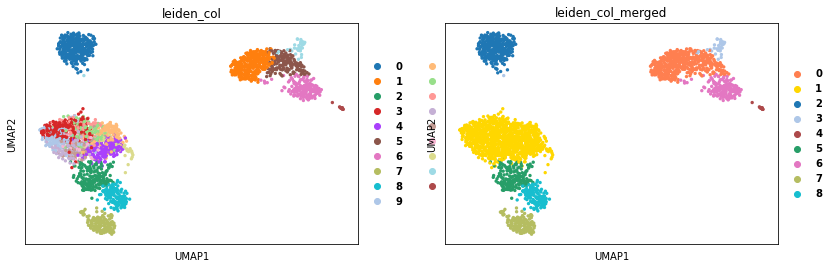

In [23]:
sc.pl.umap(data, color=[col, f'{col}_merged'], #legend_loc='on data'
          )

<AxesSubplot:title={'center':'leiden_col_merged'}, xlabel='UMAP1', ylabel='UMAP2'>

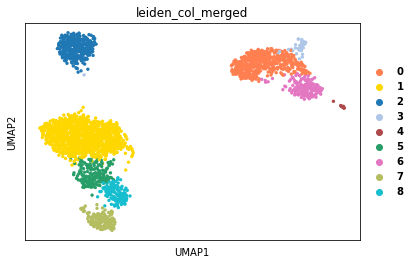

In [24]:
sc.pl.umap(data, color=f'{col}_merged', show=True)

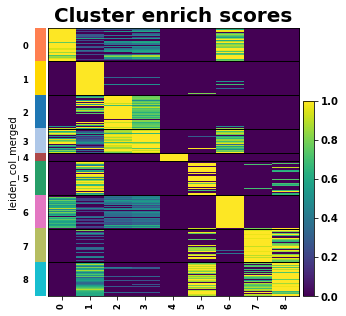

In [25]:
cc.pl.enrich_heatmap(data, f'{col}_merged', figsize=(5,5))

In [26]:
data.uns[f'{col}_merged_markers']

{'0': array(['LYZ', 'FTL', 'TYROBP', 'CST3', 'S100A9', 'S100A8'], dtype=object),
 '1': array(['LDHB', 'CD3D', 'RPS12', 'RPS27', 'RPS25', 'RPS6'], dtype=object),
 '2': array(['CD74', 'HLA-DRA', 'CD79A', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DPA1'],
       dtype=object),
 '3': array(['CD74', 'HLA-DRA', 'CST3', 'HLA-DPB1', 'HLA-DPA1', 'HLA-DRB1'],
       dtype=object),
 '4': array(['SDPR', 'GPX1', 'TAGLN2', 'GNG11', 'PF4', 'OAZ1'], dtype=object),
 '5': array(['CCL5', 'IL32', 'NKG7', 'GZMK', 'B2M', 'CTSW'], dtype=object),
 '6': array(['AIF1', 'LST1', 'FCER1G', 'FTL', 'FTH1', 'CST3'], dtype=object),
 '7': array(['NKG7', 'GNLY', 'CTSW', 'GZMB', 'PRF1', 'B2M'], dtype=object),
 '8': array(['NKG7', 'CCL5', 'CST7', 'B2M', 'GZMA', 'GZMH'], dtype=object)}

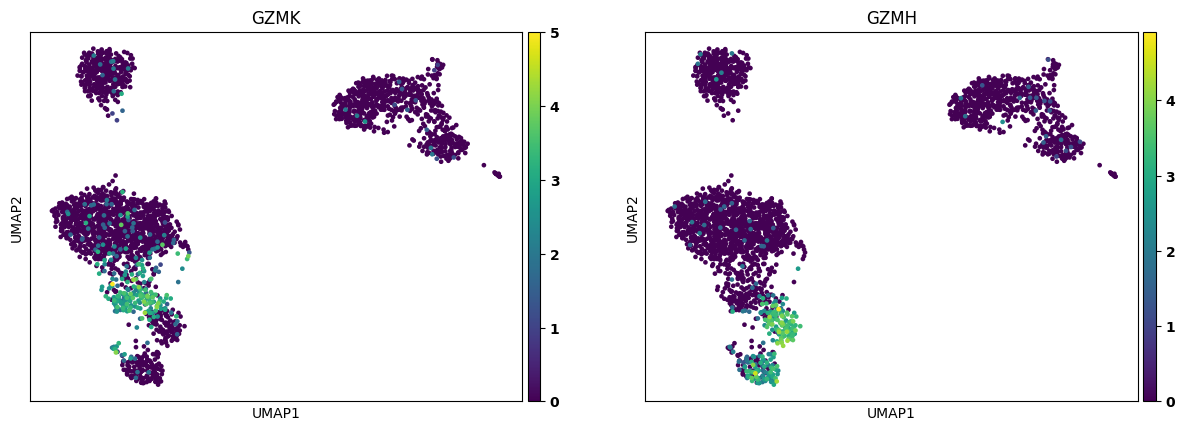

In [46]:
sc.pl.umap(data, color=['GZMK', 'GZMH'], show=True)

Printing top and bottom most significant/non-significant clusters.

Top significant
p=8.70379399990879e-19 (7 cells; 7 scores) vs (18 cells; 7 scores)
p=2.811890344301004e-29 (7 cells; 18 scores) vs (18 cells; 18 scores)


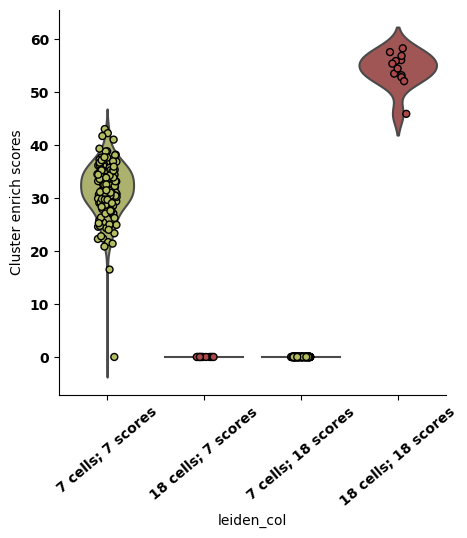

Bottom significant
p=3.000930149050119e-05 (8 cells; 8 scores) vs (2 cells; 8 scores)
p=0.618172639228006 (8 cells; 2 scores) vs (2 cells; 2 scores)


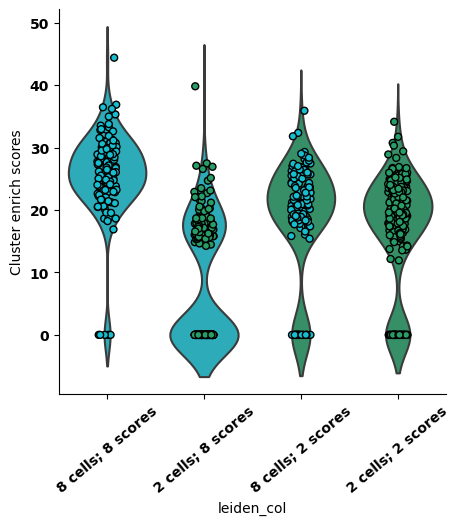

Top non-significant
p=0.9749961645884152 (11 cells; 11 scores) vs (12 cells; 11 scores)
p=0.9963140117302918 (11 cells; 12 scores) vs (12 cells; 12 scores)


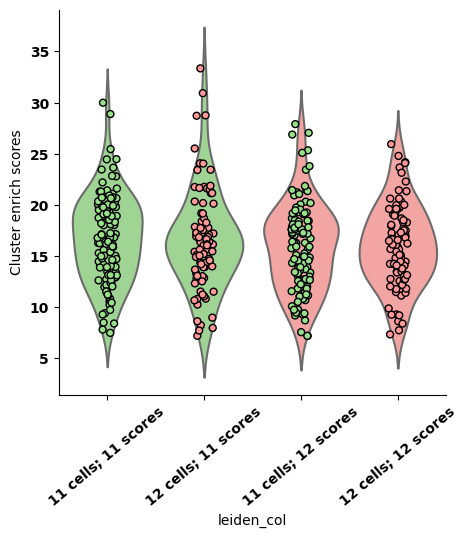

Bottom non-significnat
p=0.018925805283554302 (3 cells; 3 scores) vs (10 cells; 3 scores)
p=0.1289738793929456 (3 cells; 10 scores) vs (10 cells; 10 scores)


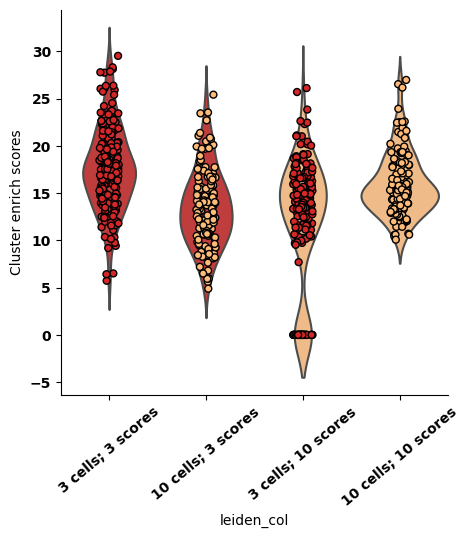

In [21]:
nts.pl.sig_cluster_diagnostics(data, col, 
                           plot_pair=None,
                           plot_examples=True,
                           skip=50,
                          )

Input pair ['3', '9']
p=0.8787464787109435 (3 cells; 3 scores) vs (9 cells; 3 scores)
p=0.9514770674188523 (3 cells; 9 scores) vs (9 cells; 9 scores)


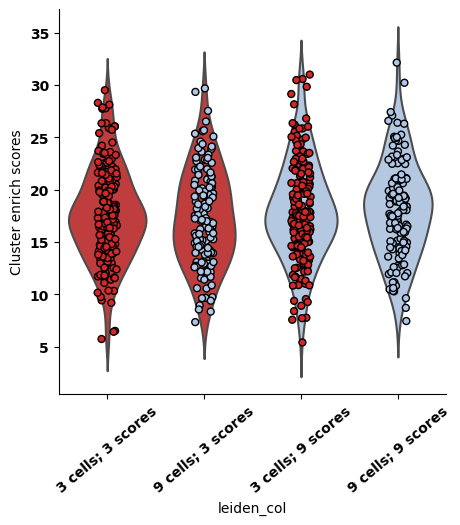

Input pair ['1', '5']
p=0.03879348800294106 (1 cells; 1 scores) vs (5 cells; 1 scores)
p=0.33451113755261985 (1 cells; 5 scores) vs (5 cells; 5 scores)


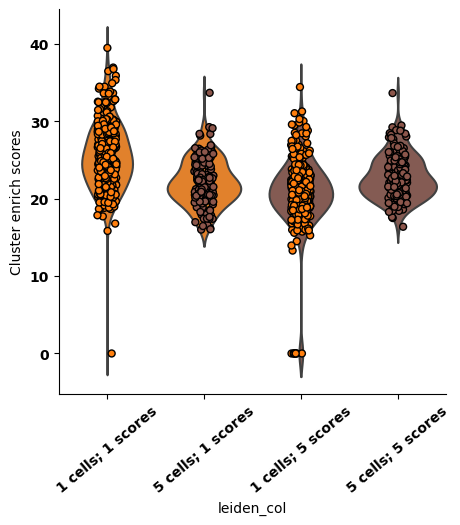

Input pair ['0', '9']
p=2.0841937484427138e-15 (0 cells; 0 scores) vs (9 cells; 0 scores)
p=0.0024995039031750223 (0 cells; 9 scores) vs (9 cells; 9 scores)


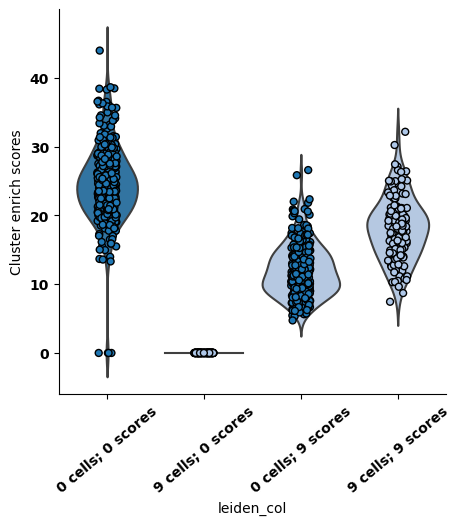

Input pair ['2', '8']
p=0.618172639228006 (2 cells; 2 scores) vs (8 cells; 2 scores)
p=3.000930149050119e-05 (2 cells; 8 scores) vs (8 cells; 8 scores)


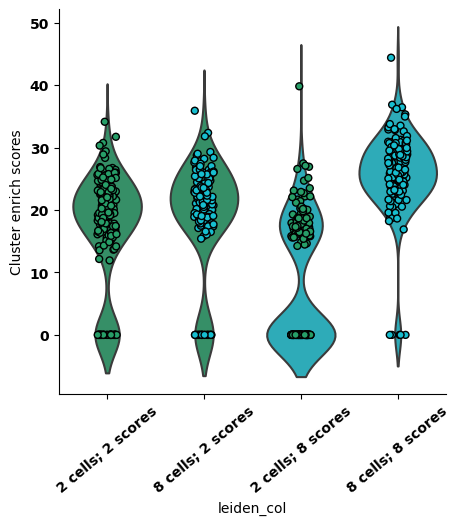

In [44]:
##### Plotting example pairs for figure, mostly to get p-values!!!!
pairs = ['3_9', '1_5', '0_9', '2_8']
for pair in pairs:
    pair = pair.split('_')
    nts.pl.sig_cluster_diagnostics(data, col, 
                           plot_pair=pair,
                          )

# Checking for bias

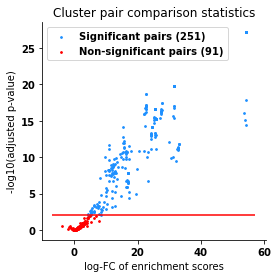

In [28]:
cc.pl.volcano(data, col, p_cut=1e-2, p_adjust=True, figsize=(4,4))

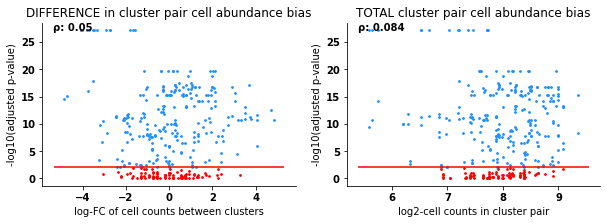

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
cc.pl.check_abundance_bias(data, col, p_cut=1e-2, p_adjust=True, show_legend=False, ax=ax[0], show=False)
cc.pl.check_total_abundance_bias(data, col, p_cut=1e-2, p_adjust=True, show_legend=False, ax=ax[1], show=False)
plt.show()

### DONE!